### Hyperbolic Tension Spline Overview
The hyperbolic tension spline model is used to transform a collection of traded forward prices into a smooth forward curve of homogenous granularity. The constructed curve will arbitrage-free and of a higher granularity than the least granular input forward contracts. This notebook describes how to use the model, as implemented in the [curves Python package](https://pypi.org/project/curves/).

#### Documentation
For detailed mathematical documentation see [tension_spline.pdf](https://github.com/cmdty/curves/blob/master/docs/tension_spline/tension_spline.pdf).

#### Comparison With Existing Curves Python Functions
The **hyberbolic_tension_spline** is a recent addition to the curves package, and is intended to supercede these existing curve building functions which are described in detail in [curves_tutorial](curves_tutorial.ipynb).
The tension parameter to the tension spline, which is described in detail below, allows more control to reduce oscillations of the interpolating function. The max_smooth_interp function used a fourth order polynomial to interpolate over each input contract time section, but an order of four is unnecessarily high for this problem and contributed to unwanted oscillations, as reported by users. Apart from the addition of a tension parameter, the implementation of the new tension spline differs from the maximum smoothness spline in the following ways:

* Functionality to interpolate overlapping contracts and apply shaping spreads and ratios. Previously the bootstrap_contracts would need to be called prior to spline interpolation to remove overlaps and apply shaping. However, these aspects of the interpolation are incorporated directly into the linear system being solved for the tension spline, as should have been done with the maximum smoothness spline.
* Written purely in Python, rather than the core being implemented in C#. This has many benefits, including:
    * No restriction on the granularity of curves which can be produced, other than what can be represented by a Pandas frequency.
    * Easier to view and debug the core calculations.
* Ability to specify the time zone of the interpolated curve.
* Arbitrary positioning of the spline knots, as determined by the caller.


#### Specifying Spline Knots
By default the knots of the spline are placed at the input contract start periods and the next period from the contract end periods. However, the two parameters **knot_positions** and **knots** can be used by the caller to control the knots.

In the examples below a high tension value is used to make visualisation of the knot positions clearer.


##### KnotPositions Enum
Instances of the KnotPositions flags enum can be passed in as arguments to the knot_positions parameter and control the automatic generation of knot positions relative to the input contract delivery periods.

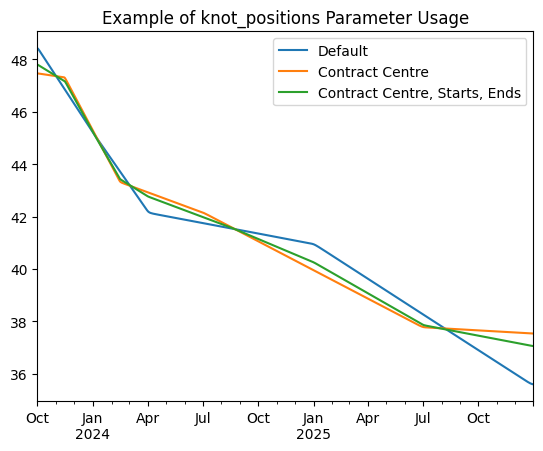

In [25]:
from curves import hyperbolic_tension_spline, KnotPositions, contract_period as cp

tension = 100.0

contracts = [
    (cp.q_4(2023), 46.85),
    (cp.q_1(2024), 43.72),
    (cp.cal_year(2024), 42.09),
    (cp.cal_year(2025), 38.25),
]

curve_default_knots = hyperbolic_tension_spline(contracts, freq='D', tension=tension)
curve_centre_knots = hyperbolic_tension_spline(contracts, freq='D', tension=tension, knot_positions=KnotPositions.CONTRACT_CENTRE)
curve_centre_start_end_knots = hyperbolic_tension_spline(contracts, freq='D', tension=tension, knot_positions=KnotPositions.SPACING_CENTRE | KnotPositions.CONTRACT_START_AND_END)

ax = curve_default_knots.plot(legend=True, title='Example of knot_positions Parameter Usage')
curve_centre_knots.plot(legend=True)
curve_centre_start_end_knots.plot(legend=True)
ax.legend(['Default', 'Contract Centre', 'Contract Centre, Starts, Ends'])

##### Specifying Individual Knots with knots Parameter
The knots parameter can used to manually specify individual knots. The final set of knots used is the intersection of those passed into knots, and those generated from the value passed in to knot_positions. An argument value of KnotPositions.NONE for knot_positions can be used to deactivate any automatic generation of knots, hence ensure only the knots parameter is used, as shown in the example below.

<Axes: title={'center': 'Example of Manually Specified Knots'}>

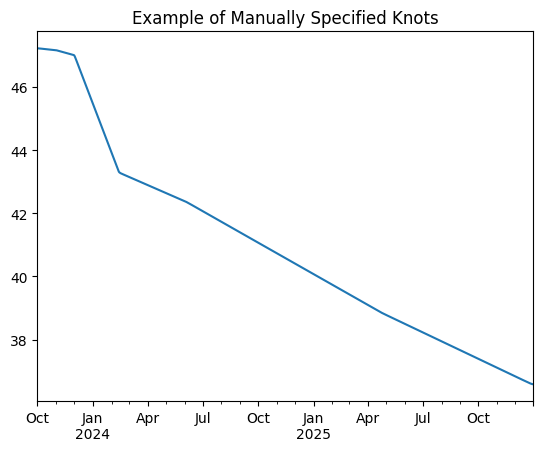

In [26]:
from datetime import date
import pandas as pd
manual_knots = [
    '2023-11-01',
    '2023-12-01',
    date(2024, 2, 13),
    pd.Period(year=2024, month=6, day=1, freq='D'),
    date(2025, 4, 24),
]

curve_manual_knots = hyperbolic_tension_spline(contracts, freq='D', tension=tension, knot_positions=KnotPositions.NONE, knots=manual_knots)

curve_manual_knots.plot(title='Example of Manually Specified Knots')

#### Applying Shaping
Many commodities shows seasonality in the day of week, such as power and gas. In these cases the curve produced by the  spline is clearly not sufficient in that such seasonality isn't reflected reflected in the smooth curve. Extra information needs to be provided to the model in order for a satisfactory interpolation. There are two ways of providing this information: shaping ratios/spreads and spline adjustment functions.

##### Shaping Spreads and Ratios
Callers of the tension spline can add constraints to the calculated curve:
* Shaping spreads constrain that the difference between the average price of the curve across two different delivery period is equal to a specified number.
* Shaping ratios constrain that the ratio between the average price of the curve across two different delivery period is equal to a specified number.

The two optional parameters **shaping_spreads** and **shaping_ratios** can be used to apply these constraints, as demonstrated in the Python code below.

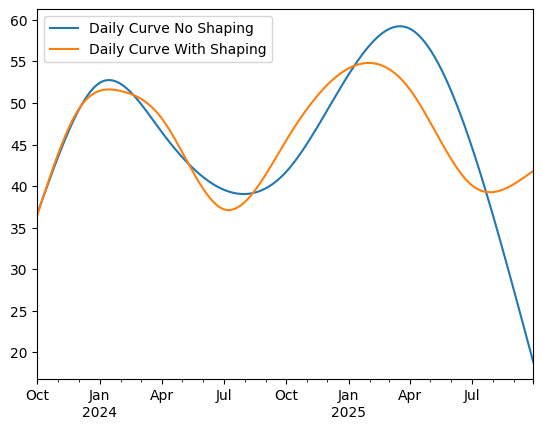

In [27]:
from curves import hyperbolic_tension_spline, contract_period as cp
import pandas as pd

tension = 0.01

contracts = [
    (cp.q_4(2023), 45.85),
    (cp.q_1(2024), 50.72),
    (cp.summer(2024), 41.09),
    (cp.winter(2024), 52.25),
    (cp.summer(2025), 42.83),
]

daily_curve_no_shaping = hyperbolic_tension_spline(contracts, freq='D', tension=tension)
daily_curve_no_shaping.plot(legend=True)

shaping_spreads = [
        
    (cp.jan(2024), cp.dec(2023), 0.98)
]

shaping_ratios = [
    
    (cp.q_3(2024), cp.q_2(2024), 0.95),
    (cp.q_3(2025), cp.q_2(2024), 0.95)
]

daily_curve_shaped = hyperbolic_tension_spline(contracts, freq='D', tension=tension, shaping_spreads=shaping_spreads, shaping_ratios=shaping_ratios)

ax = daily_curve_shaped.plot(legend=True)
ax.legend(['Daily Curve No Shaping','Daily Curve With Shaping'])

#### Controlling the Curve Slope at Start and End
One common problem with spline interpolation, is the shape of the curve at the furthest point. Without a subsequent contract to "anchor" the direction of the spline at back end of the curve, it is often the case that it will go off in a direction which does not seem correct, given the fundamentals of the commodity being modelled. The same problem can be seen at the front of the curve, but is usually less of a problem given that generally there will be higher granularity input contracts at the front, giving the spline less freedom. This problem can be mitigated with use of shaping spreads and ratios, as described above. However, a more direct method is provided by the optional front_1st_deriv and back_1st_deriv parameters. These allow the caller to specify the slope of the curve at the extremities.

See the example below, where a smooth curves are created for varying values of the back_1st_deriv argument.

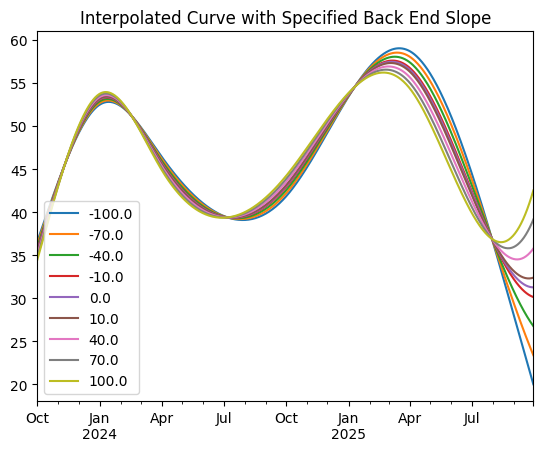

In [28]:
contracts = [
    (cp.q_4(2023), 45.85),
    (cp.q_1(2024), 50.72),
    (cp.summer(2024), 41.09),
    (cp.winter(2024), 52.25),
    (cp.summer(2025), 42.83),
]
back_end_slopes = [-100.0, -70.0, -40.0, -10.0, 0.0, 10.0, 40.0, 70.0, 100.0]
for back_1st_deriv in back_end_slopes:
    tension_curve_no_max_smooth = hyperbolic_tension_spline(contracts, freq='D', tension=tension, back_1st_deriv=back_1st_deriv)
    ax = tension_curve_no_max_smooth.plot(legend=True, title='Interpolated Curve with Specified Back End Slope')

ax.legend(back_end_slopes)

#### Setting the Time Zone
If interpolating to an granularity that is higher than daily, which will typically be the case for electricity, clock changes will need to be taken into account in the returned curve. This can only be done if the tension spline algorithm has information about the time zone of the market. The time_zone parameter is used to achieve this. It is advisable that callers always assignt to time_zone when interpolating to higher than daily frequency.

The example below shows the interpolation of four-hourly (EFA) blocks prices to half-hourly granularity. This is across a clock change backwards, hence an hour in local time is duplicated. The displayed chart x-axis is in local time, hence the repeated hour is clear from the kink.

C:\Users\fowle\AppData\Local\Temp\ipykernel_12324\842342041.py:11: FutureWarning: PeriodIndexResampler.fillna is deprecated and will be removed in a future version. Use obj.ffill(), obj.bfill(), or obj.nearest() instead.
  ax = four_hour_block_series.resample('30min').fillna('pad').plot(legend=True)


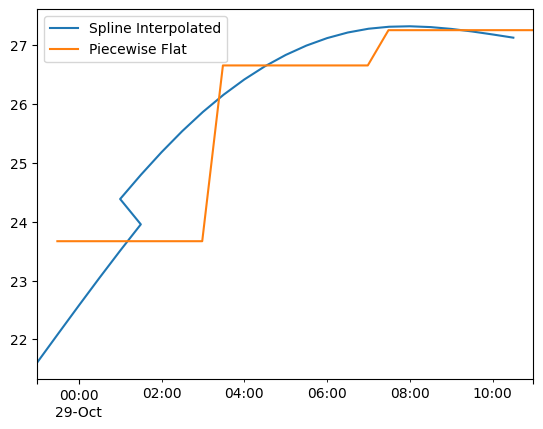

In [29]:
time_zone = 'Europe/London'

tension = 0.01
intraday_data=[23.67, 26.66, 27.26]
intraday_index=pd.period_range(start='2023-10-28 23:00:00', periods=len(intraday_data), freq='4H')
four_hour_block_series = pd.Series(data=intraday_data, index=intraday_index)

half_hourly_curve = hyperbolic_tension_spline(four_hour_block_series, freq='30min', tension=tension, time_zone=time_zone)

half_hourly_curve.plot(legend=True)
ax = four_hour_block_series.resample('30min').fillna('pad').plot(legend=True)
ax.legend(['Spline Interpolated', 'Piecewise Flat'])

If the time zone is specified the returned pandas.Series instance will have an index of type DatetimeIndex, rather than the default PeriodIndex type.

Note that it is not advisable to set the time zone for daily and lower (e.g. monthly) granularity interpolation frequency. A time zone for such interpolation frequencies does not really make sense, and although the tension spline will execute, testing has shown unexpected behaviour. 

#### Retrieving Solved Spline Coefficients
It might be useful to access the tension spline coeffients which were solved for. If the optional parameter return_spline_coeff is set to True, the tension spline function will return a 2-tuple, with the first element being the interpolated curve which is usually returned, and the second element a Pandas DataFrame containing solved parameters.

The example below shows the DataFrame contains not only the solved $y_i$ and $z_i$ coefficients, but also the value of the time $t$ variable (calculated as time in years) at each of the knots. The final column shows the rescaled tension, and as this is calculated per spline section, these values are indexed by the knot at which the section start. As there are one fewer sections than there are knots, the final knot does not have a section, so the tension for the final row is set to NaN.

In [30]:
tension = 0.01
contracts = [
    (cp.q_4(2023), 45.85),
    (cp.q_1(2024), 50.72),
]

_, solved_coefficients = hyperbolic_tension_spline(contracts, freq='D', tension=tension, return_spline_coeff=True)

solved_coefficients

,t,y,z,tension
2023-10-01,0.000000,43.428314,0.001891,0.039674
2024-01-01,0.252055,48.324919,-0.000157,0.040556
2024-03-31,0.498630,53.115070,-0.001963,NaN
